Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib import cm
import datetime as dt
import os
import openpyxl
from osgeo import gdal
import netCDF4
from dateutil.relativedelta import relativedelta
import re
import pandas as pd
import xarray as xr
import geopandas as gpd
import glob
from datetime import datetime
from colorama import Fore #for colored terminal text and cursor positioning
from osgeo import ogr, gdal, osr #for raster operations

## Processing Spatial SWAT+ outputs

#### Import SWAT+ txt output file

The SWAT+ output used in this notebook is the monthly hru water balance file (hru_wb_mon.txt)

The first row is skipped since it contains the summary of model version. The next row is similary skipped since it contains the column units


In [2]:
#path to hru file
path= r'H:\raw_cordex_rcmdata\for_swatplus\swat+_models\racmo22t\nyando_cca_hist\Scenarios\Default\TxtInOut'

col_names = ['jday', 'mon', 'day', 'yr', 'unit', 'gis_id', 'name', 'precip', 'snofall', 'snomlt', 'surq_gen', 'latq', 'wateryld', 'perc', 'et', 'ecanopy', 'eplant', 'esoil', 'surq_cont', 'cn', 'sw_init', 'sw_final', 'sw_ave', 'sw_300', 'sno_init', 'sno_final', 'snopack', 'pet', 'qtile', 'irr', 'surq_runon', 'latq_runon', 'overbank', 'surq_cha', 'surq_res', 'surq_ls', 'latq_cha', 'latq_res', 'latq_ls', 'gwtranq', 'satex', 'satex_chan', 'sw_change', 'lagsurf', 'laglatq', 'lagsatex']
             
hru_wb_mon= pd.read_csv(path +'\hru_wb_mon.txt',  delim_whitespace=True,skiprows=3,names=col_names) 
#  delimiter = r'\s+' also same as delim_whitespace #s+ is a regular expression for one or more spaces.
dataset=hru_wb_mon

### Import HRU Shapefile

In [4]:

hrus= gpd.read_file(r'H:\raw_cordex_rcmdata\for_swatplus\swat+_models\racmo22t\nyando_cca_hist\Watershed\Shapes\hrus1.shp')
#fig, ax = plt.subplots(figsize=(6,6))
#hrus.plot(ax=ax, **{'edgecolor':'k', 'facecolor':'white'})
hrus.crs #get projection info

<Projected CRS: EPSG:32637>
Name: WGS 84 / UTM zone 37N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 36°E and 42°E, northern hemisphere between equator and 84°N, onshore and offshore. Djibouti. Egypt. Eritrea. Ethiopia. Georgia. Iraq. Jordan. Kenya. Lebanon. Russian Federation. Saudi Arabia. Somalia. Sudan. Syria. Turkey. Ukraine.
- bounds: (36.0, 0.0, 42.0, 84.0)
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
hru_names=hrus[['HRUS','geometry']]
hrus['hrus']=('hru'+hrus.loc[:,'HRUS']) #Create a column with hru names appended to hru numbers
hrus

,Subbasin,Channel,Landscape,Landuse,Soil,SlopeBand,Area,%Subbasin,%Landscape,HRUS,LINKNO,geometry,hrus
0,1,66,NA,COFF,Nh2-2c-848,0-8,271.35,17.8,41.5,1,8,"MULTIPOLYGON (((77060.638 12062.715, 77060.638...",hru1
1,1,66,NA,COFF,Nh2-2c-848,8-16,305.37,20.0,46.7,2,8,"MULTIPOLYGON (((77690.638 11882.715, 77420.638...",hru2
2,1,66,NA,COFF,Nh2-2c-848,16-32,72.09,4.7,11.0,3,8,"MULTIPOLYGON (((77150.638 11702.715, 77060.638...",hru3
3,1,66,NA,COFF,Nh2-2c-848,32-9999,5.67,0.4,0.9,4,8,"MULTIPOLYGON (((78590.638 9362.715, 78590.638 ...",hru4
4,1,65,NA,COFF,Nh2-2c-848,8-16,47.79,3.1,9.5,5,16,"MULTIPOLYGON (((75080.638 11612.715, 75080.638...",hru5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,204,1070,NA,CORN,Nh2-2c-848,32-9999,4.86,0.3,2.2,7347,111,"POLYGON ((55100.638 -42747.285, 55100.638 -425...",hru7347
7347,204,1070,NA,BSVG,Nh2-2c-848,16-32,5.67,0.4,2.6,7348,111,"MULTIPOLYGON (((55460.638 -42747.285, 55370.63...",hru7348
7348,204,1070,NA,BSVG,Nh2-2c-848,8-16,21.06,1.3,9.7,7349,111,"MULTIPOLYGON (((56090.638 -42837.285, 56000.63...",hru7349
7349,204,1070,NA,BSVG,Nh2-2c-848,0-8,5.67,0.4,2.6,7350,111,"MULTIPOLYGON (((56090.638 -42747.285, 56090.63...",hru7350


### Convert data types
Some numeric datatypes are read as as str types.
Convert the column values from the previous step to floats and append the float data as new columns in the dataframe.
Values with scientific notations are also read as string type, convert colums of interest to float and add the new cols
If no data in scientific format, this step can be skipped

Convert the datetime columns to integers and combine the dataframes

In [6]:
data_float=dataset.loc[:,['precip','et', 'pet','wateryld']].astype(float) #data columns to be converted to floats
data_int=dataset.loc[:,['mon','day','yr']]#.astype(int) #data columns to be converted to integers

data_extract=data_int.merge(data_float, left_index=True, right_index=True)
data_extract['HRUS']=dataset['name'] 
#pd.reset_option('display.float_format') #reset to default number of float decimals
#type(data_float['precip'])
#rename the HRU names to match those in the HRU shapefile
data_extract

,mon,day,yr,precip,et,pet,wateryld,HRUS
0,1,31,1982,39.74,121.085,149.349,0.183,hru0001
1,1,31,1982,39.74,120.155,149.352,1.647,hru0002
2,1,31,1982,39.74,119.365,149.355,2.023,hru0003
3,1,31,1982,39.74,118.108,149.384,1.471,hru0004
4,1,31,1982,39.74,120.190,149.357,1.611,hru0005
...,...,...,...,...,...,...,...,...
2117083,12,31,2005,30.38,30.380,146.404,0.000,hru7347
2117084,12,31,2005,30.38,38.334,146.207,0.000,hru7348
2117085,12,31,2005,30.38,40.895,146.194,0.000,hru7349
2117086,12,31,2005,30.38,46.595,146.164,0.000,hru7350


### Rename the HRUs 
Rename HRU names in the dataframe to match the hru names in the shapefile
select the last 4 digits of the name and convert to integer

In [7]:
data_extract['hrus_int'] =(data_extract.loc[:,'HRUS'].str[-4:]).astype(int)
#data_extract['hrus_int']=data_extract.loc[:,'hrus_rename'].astype(int)
data_extract['hrus']=('hru'+data_extract.loc[:,'hrus_int'].map(str))
data_extract

,mon,day,yr,precip,et,pet,wateryld,HRUS,hrus_int,hrus
0,1,31,1982,39.74,121.085,149.349,0.183,hru0001,1,hru1
1,1,31,1982,39.74,120.155,149.352,1.647,hru0002,2,hru2
2,1,31,1982,39.74,119.365,149.355,2.023,hru0003,3,hru3
3,1,31,1982,39.74,118.108,149.384,1.471,hru0004,4,hru4
4,1,31,1982,39.74,120.190,149.357,1.611,hru0005,5,hru5
...,...,...,...,...,...,...,...,...,...,...
2117083,12,31,2005,30.38,30.380,146.404,0.000,hru7347,7347,hru7347
2117084,12,31,2005,30.38,38.334,146.207,0.000,hru7348,7348,hru7348
2117085,12,31,2005,30.38,40.895,146.194,0.000,hru7349,7349,hru7349
2117086,12,31,2005,30.38,46.595,146.164,0.000,hru7350,7350,hru7350


### Extract and summarize selected hru water balance components

Create monthly and annual summaries of hru water components using a pivot table function

In [8]:
def analyze_summary(dataframe):
        #create a date column by concatenating date elements and set the new date column as data index
        dataframe['full_date']=dataframe['day'].map(str)+'-'+dataframe['mon'].map(str)+'-'+dataframe['yr'].map(str)
        dataframe['date']=pd.to_datetime(dataframe['full_date'][1:])
        dataframe.set_index('date')
        dataframe['month'] = pd.DatetimeIndex(dataframe['date']).month #extract month from output
        dataframe['year'] = pd.DatetimeIndex(dataframe['date']).year #extract year from output
    
        #create a pivot with time summary of variable of interest e.g et.
        #Declaring global variables makes them accessible outside of the function
        global dataframe_monthly
        global dataframe_annual
        global variable_names
        variable_names=['et','precip', 'wateryld','pet']
        
        #create monthly means and annual total water balance output using pivot table
        dataframe_monthly=dataframe.pivot_table(index='hrus', values=variable_names[0], columns='month', aggfunc='mean')
        dataframe_annual=dataframe.pivot_table(index='hrus', values=variable_names[0], columns='year', aggfunc='sum')
        dataframe_annual.columns=dataframe_annual.columns.map(int)
        months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']
        
        dataframe_monthly.columns=months
        dataframe_annual.columns=str(variable_names[0])+'_'+dataframe_annual.columns.map(str)
                
        return dataframe_annual

analyze_summary(data_extract)

year,et_1982,et_1983,et_1984,et_1985,et_1986,et_1987,et_1988,et_1989,et_1990,et_1991,...,et_1996,et_1997,et_1998,et_1999,et_2000,et_2001,et_2002,et_2003,et_2004,et_2005
hrus,,,,,,,,,,,,,,,,,,,,,
hru1,1072.695,1213.714,900.136,903.607,876.168,968.362,906.756,948.329,916.279,849.989,...,1166.805,966.880,875.665,993.276,944.251,866.292,921.610,929.405,912.541,861.917
hru10,1255.282,1284.455,1189.067,1195.420,1199.527,1190.043,1225.875,1354.947,1397.655,1166.519,...,1268.778,1177.685,1345.791,1366.777,1201.758,1311.453,1421.722,1235.268,1398.523,1324.991
hru100,1180.589,1224.807,425.967,427.605,416.971,467.200,448.781,488.312,468.399,446.618,...,1450.953,854.918,434.889,838.325,506.671,480.980,450.872,469.410,502.432,436.554
hru1000,1299.289,1435.373,1308.019,1227.424,1357.679,1390.570,1235.152,1477.201,1424.931,1270.558,...,1421.449,1309.326,1363.725,1454.022,1313.148,1340.705,1450.833,1421.114,1419.651,1347.884
hru1001,1282.095,1420.081,1295.563,1227.509,1340.129,1386.836,1234.821,1477.342,1425.351,1262.361,...,1410.789,1296.627,1364.327,1432.349,1299.531,1341.191,1451.186,1405.942,1420.180,1348.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hru995,1280.103,1363.976,1264.385,1204.447,1324.284,1395.020,1232.586,1447.221,1400.746,1294.973,...,1404.134,1266.044,1342.880,1406.807,1311.878,1319.842,1429.064,1426.055,1394.174,1323.118
hru996,1279.504,1363.970,1264.004,1204.643,1324.404,1393.657,1232.841,1448.364,1401.079,1293.019,...,1405.196,1266.523,1343.758,1406.654,1311.380,1321.194,1430.023,1425.850,1394.498,1324.319
hru997,1285.905,1371.260,1271.086,1214.192,1335.586,1403.047,1245.193,1465.293,1410.845,1295.181,...,1419.810,1283.668,1364.267,1421.156,1321.513,1341.866,1445.616,1434.332,1395.596,1341.286


### Join SWAT+ outputs with HRU shapefile
Import the hru shapefile which corresponds with the output data and create individual annual geodataframes of the selected wb output.Use the hrus fields as the common join field

In [9]:
#min_yr, max_yr=dataframe_annual.columns.min(), dataframe_annual.columns.max() #extract start and end yr from the dataframe
from rich.progress import track
import time
for i in track(range(1),description="append progress"): #progress bar
    
    annual_totals=[]
    wb_data_gpd=[]
    for col in dataframe_annual.columns[0:]:
        #print(dataframe_annual[col])
        wb_data=dataframe_annual.loc[:,[col]].merge(hrus, on='hrus', how='left') #merge wb output for each year to the hrus geodataframe
        annual_totals.append(wb_data)

    for i in range(0,len(annual_totals)):
        wb_gpd=gpd.GeoDataFrame(annual_totals[i], geometry='geometry')
        wb_data_gpd.append(wb_gpd)
        wb_data_gpd[i][variable_names[0]] = wb_data_gpd[i].iloc[:,[1]] #duplicate 'yyyy_variable_name' column as 'variable name only'
        time.sleep(0.1)

Output()

### Export yearly water balance output as a separate shapefile

#### Function to create a data output folder

In [10]:
def create_path(path_name):
    parent_dir =os.path.split(os.getcwd())[0] #path to parent folder
    out_folder = path_name
    out_path = os.path.join(parent_dir, out_folder)
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    print("your outputs will be written to:", out_path)
    
    return out_path

#### Write shapefiles to shapefile folder from previous step

In [11]:
shp_path=create_path('wb_shapefiles') #folder to store shapefiles

#export annual wb output to shapefile
print('writing '+ variable_names[0] + ' to shapefile...')
for i in range(len(wb_data_gpd)):
    wb_data_gpd[i].drop('HRUS',axis=1).to_file(shp_path+'\\wb_'+wb_data_gpd[i].columns[1]+ '.shp', driver='ESRI Shapefile')
    #drop hrus column because it is a duplicate column
print(Fore.BLUE,'wb output successfully exported!')

your outputs will be written to: E:\codes_jupyter\paper_publication\wb_shapefiles
writing et to shapefile...
 wb output successfully exported!


### Plotting shapefile data

Text(0.5, 1.0, 'et_1998')

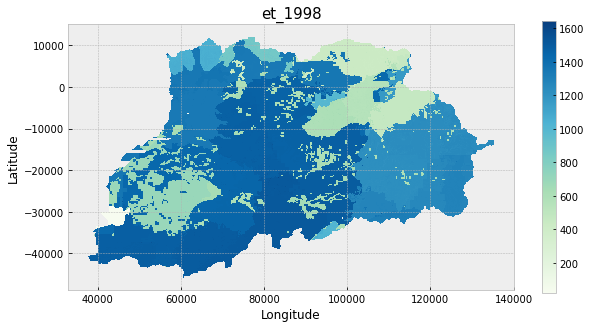

In [23]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

# Plot data
# Reference: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
wb_data_gpd[16].plot(column =wb_data_gpd[16].columns[1],ax = ax,cmap = "GnBu",legend = True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title(wb_data_gpd[16].columns[1], fontdict = {'fontsize': '15', 'fontweight' : '3'})

### Export shapefiles to raster layers

In [12]:
#create a raster folder
raster_path=create_path('wb_rasters')
#####################################################################
shp_path=shp_path #path to shapefiles
shp_output=[]
shp_list = [file for file in os.listdir(shp_path) if file[-4:]=='.shp']

print('Exporting raster files...')
for i in range(0, len(shp_list)):
    shp=ogr.Open(shp_path + '/' + shp_list[i]) #loop through all shapefiles and read
    shp_output.append(shp) #append the shapefiles in a list

    input_layer=shp.GetLayer() #getting layer information of shapefile  
    input_srs = input_layer.GetSpatialRef()

    outraster_path=raster_path +'\\'+shp_list[i][:-4]+'.tif'

    pixel_size = 30
    x_min, x_max, y_min, y_max = input_layer.GetExtent()

    #calculate size / resolution of the raster.
    x_res = int(round((x_max - x_min) / pixel_size))
    y_res = int(round((y_max - y_min) / pixel_size))
    
    #passing the filename, x and y direction resolution, no.of bands, new raster.
    target_ds = gdal.GetDriverByName('GTiff').Create(outraster_path, x_res, y_res, 1, gdal.GDT_Float32,['COMPRESS=LZW'])

    #transforms between pixel raster space to projection coordinate space.
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

    #target_dsSRS.ImportFromProj4(crs)
    target_dsSRS = osr.SpatialReference()
    proj='EPSG:32637'
    target_dsSRS.SetWellKnownGeogCS(proj)
    target_ds.SetProjection(target_dsSRS.ExportToWkt())
    
    #get required raster band.
    band=target_ds.GetRasterBand(1)
    no_data_value = -9999
    band.SetNoDataValue(no_data_value)
    band.Fill(-9999)
    band.FlushCache()

    #conversion
    gdal.RasterizeLayer(target_ds, [1], input_layer, None, None, [1], options=['ATTRIBUTE=et'])
    target_ds=None
    
print(Fore.BLUE, 'All shapefiles successfully rasterized!')

your outputs will be written to: E:\codes_jupyter\paper_publication\wb_rasters
Exporting raster files...
 All shapefiles successfully rasterized!


### Export shapefiles to raster layers

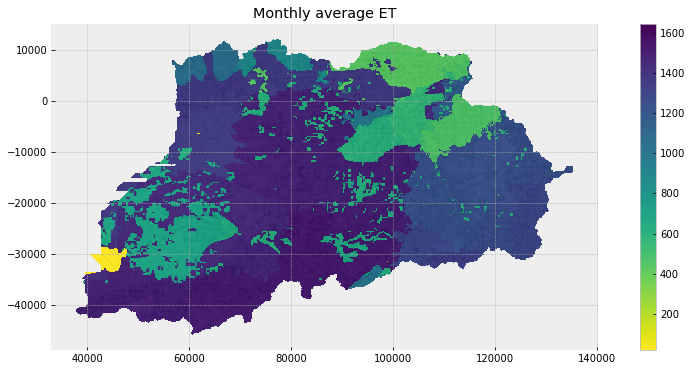

In [19]:
#Alternative plotting
ax=wb_data_gpd[16].boundary.plot(edgecolor='k', linewidth=0.01, figsize=(15,6))
wb_data_gpd[16].plot(ax=ax, column='et', legend=True, cmap='viridis_r')
             #legend_kwds={'shrink':0.6, 'orientation': 'horizontal'})
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

for edge in ['right', 'bottom', 'top', 'left']:
    ax.spines[edge].set_visible(False)
    ax.set_title('Monthly average ET')
    
plt.show()

### References

References:
https://www.youtube.com/watch?v=lQW9zK79M80&ab_channel=GeoGISLabs

https://www.programcreek.com/python/example/101827/gdal.RasterizeLayer

Ref: https://stackoverflow.com/questions/66705955/creating-subplots-through-a-loop-from-a-dataframe